## Ex-03

### Task-01

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture

In [2]:
class CouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.input1 = int(np.round(self.input_size/2))
        self.input2 = self.input_size-self.input1
        self.encoder = nn.Sequential(
            nn.Linear(self.input1, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 2 * self.input2)
            )

    def forward(self, x, rev=False):
        x1, x2 = x[...,:self.input1], x[..., self.input1:]
        param = self.encoder(x1)
        scale, translation = param[..., :self.input2], param[..., self.input2:]
        scale = torch.tanh(scale)
        log_jacob_det = torch.sum(scale, -1)

        if rev:
            scale = torch.exp(-scale)
            x2 = scale*(x2-translation)
            return torch.cat([x1,x2], -1)
        else:
            scale = torch.exp(scale)
            x2 = scale*x2 + translation
            return torch.concat([x1,x2], -1), log_jacob_det

In [3]:
def gram_schmidt(matrix):
    n, _ = matrix.shape
    orthogonal_matrix = torch.zeros_like(matrix)

    for i in range(n):
        vector = matrix[i]
        for j in range(i):
            proj = torch.dot(vector, orthogonal_matrix[j]) * orthogonal_matrix[j]
            vector = vector - proj
        orthogonal_matrix[i] = vector / torch.norm(vector)
    
    return orthogonal_matrix

class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks
        
        self.coupling_blocks = nn.ModuleList()
        for _ in range(blocks):
            self.coupling_blocks.append(CouplingLayer(input_size, hidden_size))
        
        random_matrices = [torch.randn(input_size, input_size) for _ in range(blocks - 1)]
        self.orthogonal_matrices = [gram_schmidt(matrix) for matrix in random_matrices]

    def forward(self, x, rev=False):
        if rev:
            for i in range(self.blocks - 1, 0, -1):
                x = self.coupling_blocks[i](x, rev=True)
                x = torch.matmul(x, self.orthogonal_matrices[i - 1].T)
            x = self.coupling_blocks[0](x, rev=True)
            return x
        else:
            log_jacob_det = torch.zeros((x.shape[0]), device=x.device)
            for i in range(self.blocks - 1):
                x, x_log_jacob_det = self.coupling_blocks[i](x)
                log_jacob_det += x_log_jacob_det
                x = torch.matmul(x, self.orthogonal_matrices[i])
            x, x_log_jacob_det = self.coupling_blocks[-1](x)
            log_jacob_det += x_log_jacob_det
            return x, log_jacob_det
    
    def sample(self, num_samples):
        z = torch.normal(mean=torch.zeros((num_samples, self.input_size)), std=torch.ones((num_samples,self.input_size)))
        return self.forward(z, rev=True)

In [ ]:
# Define the training function
def train_inn(model, data_loader, optimizer, epochs):
    for _ in range(epochs):
        for x, _ in data_loader:
            optimizer.zero_grad()

            x = x.view(x.size(0), -1)
            z, log_det = model(x)
            loss = torch.mean(0.5 * torch.sum(z**2, dim=1) - log_det)
            
            loss.backward()
            optimizer.step()

        # print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')


In [5]:
def generate_data(n_samples=1000, noise=0.1):
    data, _ = make_moons(n_samples=n_samples, shuffle=True, noise=noise)

    data = StandardScaler().fit_transform(data)
    
    data = torch.tensor(data, dtype=torch.float32)
    return data

def generate_data(n_samples=1000, noise=0.1, random_state=1): # ensure reproducibility for testing
    data, _ = make_moons(n_samples=n_samples, shuffle=True, noise=noise, random_state=random_state)

    data = StandardScaler().fit_transform(data)
    
    data = torch.tensor(data, dtype=torch.float32)
    return data

In [6]:
def evaluate_model(model, test_data):
    # set model in evaluation mode
    model.eval()

    total_loss = 0
    with torch.no_grad(): #ensure model's weights does not change
        
        z, log_det = model(test_data)
        loss = torch.mean(0.5 * torch.sum(z**2, dim=1) - log_det)
        
        total_loss+=loss.item()
    return total_loss/len(test_data)

In [7]:
def plot_hyperparameter_combinations(data, n_samples, input_size, lr, hidden_size_list, blocks_list, epochs_list):

    hyperparam_comb = list(itertools.product(hidden_size_list, blocks_list, epochs_list))
    len_comb = len(hyperparam_comb)
    
    # subplot grid size
    n_cols = 4
    n_rows = (len_comb + n_cols - 1) // n_cols
    
    # Create the subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    axes = axes.flatten()  # Flatten axes for easy indexing
    
    for i, (hidden_size, blocks, epochs) in enumerate(hyperparam_comb):
        ax = axes[i]

        # Initialize the RealNVP model
        model = RealNVP(input_size, hidden_size=hidden_size, blocks=blocks)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train the model
        dataset = TensorDataset(data, torch.zeros(data.size(0)))
        data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
        train_inn(model, data_loader, optimizer, epochs=epochs)

        # Generate synthetic samples
        samples = model.sample(n_samples).detach().numpy()

        # Scatter plot: generated vs original
        ax.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Original')
        ax.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label='Generated')
        ax.set_title(f'Epochs: {epochs}, Hidden_size: {hidden_size}, Blocks: {blocks}')
        ax.legend()

    # Remove unused subplots if combinations < total subplots
    for i in range(len(hyperparam_comb), len(axes)):
        fig.delaxes(axes[i])


    plt.tight_layout()
    plt.show()

In [8]:
def evaluate_hyperparameters(n_samples, input_size, lr, hidden_size_list, blocks_list, epochs_list):

    results = []

    train_data = generate_data(n_samples=n_samples, noise=0.1, random_state=1)
    test_data = generate_data(n_samples=n_samples, noise=0.1, random_state=1)

    train_dataset = TensorDataset(train_data, torch.zeros(train_data.size(0)))
    data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    for hidden_size in hidden_size_list:
        for blocks in blocks_list:
            
            model = RealNVP(input_size, hidden_size=hidden_size, blocks=blocks)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            for epochs in epochs_list:
                train_inn(model, data_loader, optimizer, epochs)
                test_loss = evaluate_model(model, test_data)
                            

                results.append({
                    'hidden_size': hidden_size,
                    'blocks': blocks,
                    'epochs': epochs,
                    'test_loss': test_loss
                })
                print(f'hidden_size={hidden_size}, blocks={blocks}, epochs={epochs} -> test_loss: {test_loss:3f}')

    # plotting scatter plots
    plot_hyperparameter_combinations(train_data, n_samples, input_size, lr, hidden_size_list, blocks_list, epochs_list)

    # plotting loss
    param_keys = ['hidden_size', 'blocks', 'epochs']
    fig, axes = plt.subplots(1, len(param_keys), figsize=(len(param_keys)*4,3))
    
    for i, key in enumerate(param_keys):
        param_vals = sorted(set([result[key] for result in results]))
        mean_losses = []
        for val in param_vals:
            losses = [result['test_loss'] for result in results if result[key]==val]
            mean_losses.append(np.mean(losses))

        axes[i].plot(param_vals, mean_losses, marker='o')
        axes[i].set_title(f'Reconstruction Error for {key}')
        axes[i].set_xlabel(key)
        axes[i].set_ylabel('Reconstruction error')
        axes[i].grid()
    
    plt.tight_layout()
    plt.show()


                         
    return results

hidden_size=32, blocks=6, epochs=10 -> test_loss: 0.000410
hidden_size=32, blocks=6, epochs=100 -> test_loss: 0.000168
hidden_size=32, blocks=8, epochs=10 -> test_loss: 0.000485
hidden_size=32, blocks=8, epochs=100 -> test_loss: 0.000176
hidden_size=32, blocks=10, epochs=10 -> test_loss: 0.000323
hidden_size=32, blocks=10, epochs=100 -> test_loss: 0.000038
hidden_size=64, blocks=6, epochs=10 -> test_loss: 0.000361
hidden_size=64, blocks=6, epochs=100 -> test_loss: 0.000120
hidden_size=64, blocks=8, epochs=10 -> test_loss: 0.000393
hidden_size=64, blocks=8, epochs=100 -> test_loss: 0.000158
hidden_size=64, blocks=10, epochs=10 -> test_loss: 0.000316
hidden_size=64, blocks=10, epochs=100 -> test_loss: 0.000071
hidden_size=128, blocks=6, epochs=10 -> test_loss: 0.000363
hidden_size=128, blocks=6, epochs=100 -> test_loss: 0.000053
hidden_size=128, blocks=8, epochs=10 -> test_loss: 0.000391
hidden_size=128, blocks=8, epochs=100 -> test_loss: 0.000055
hidden_size=128, blocks=10, epochs=10 ->

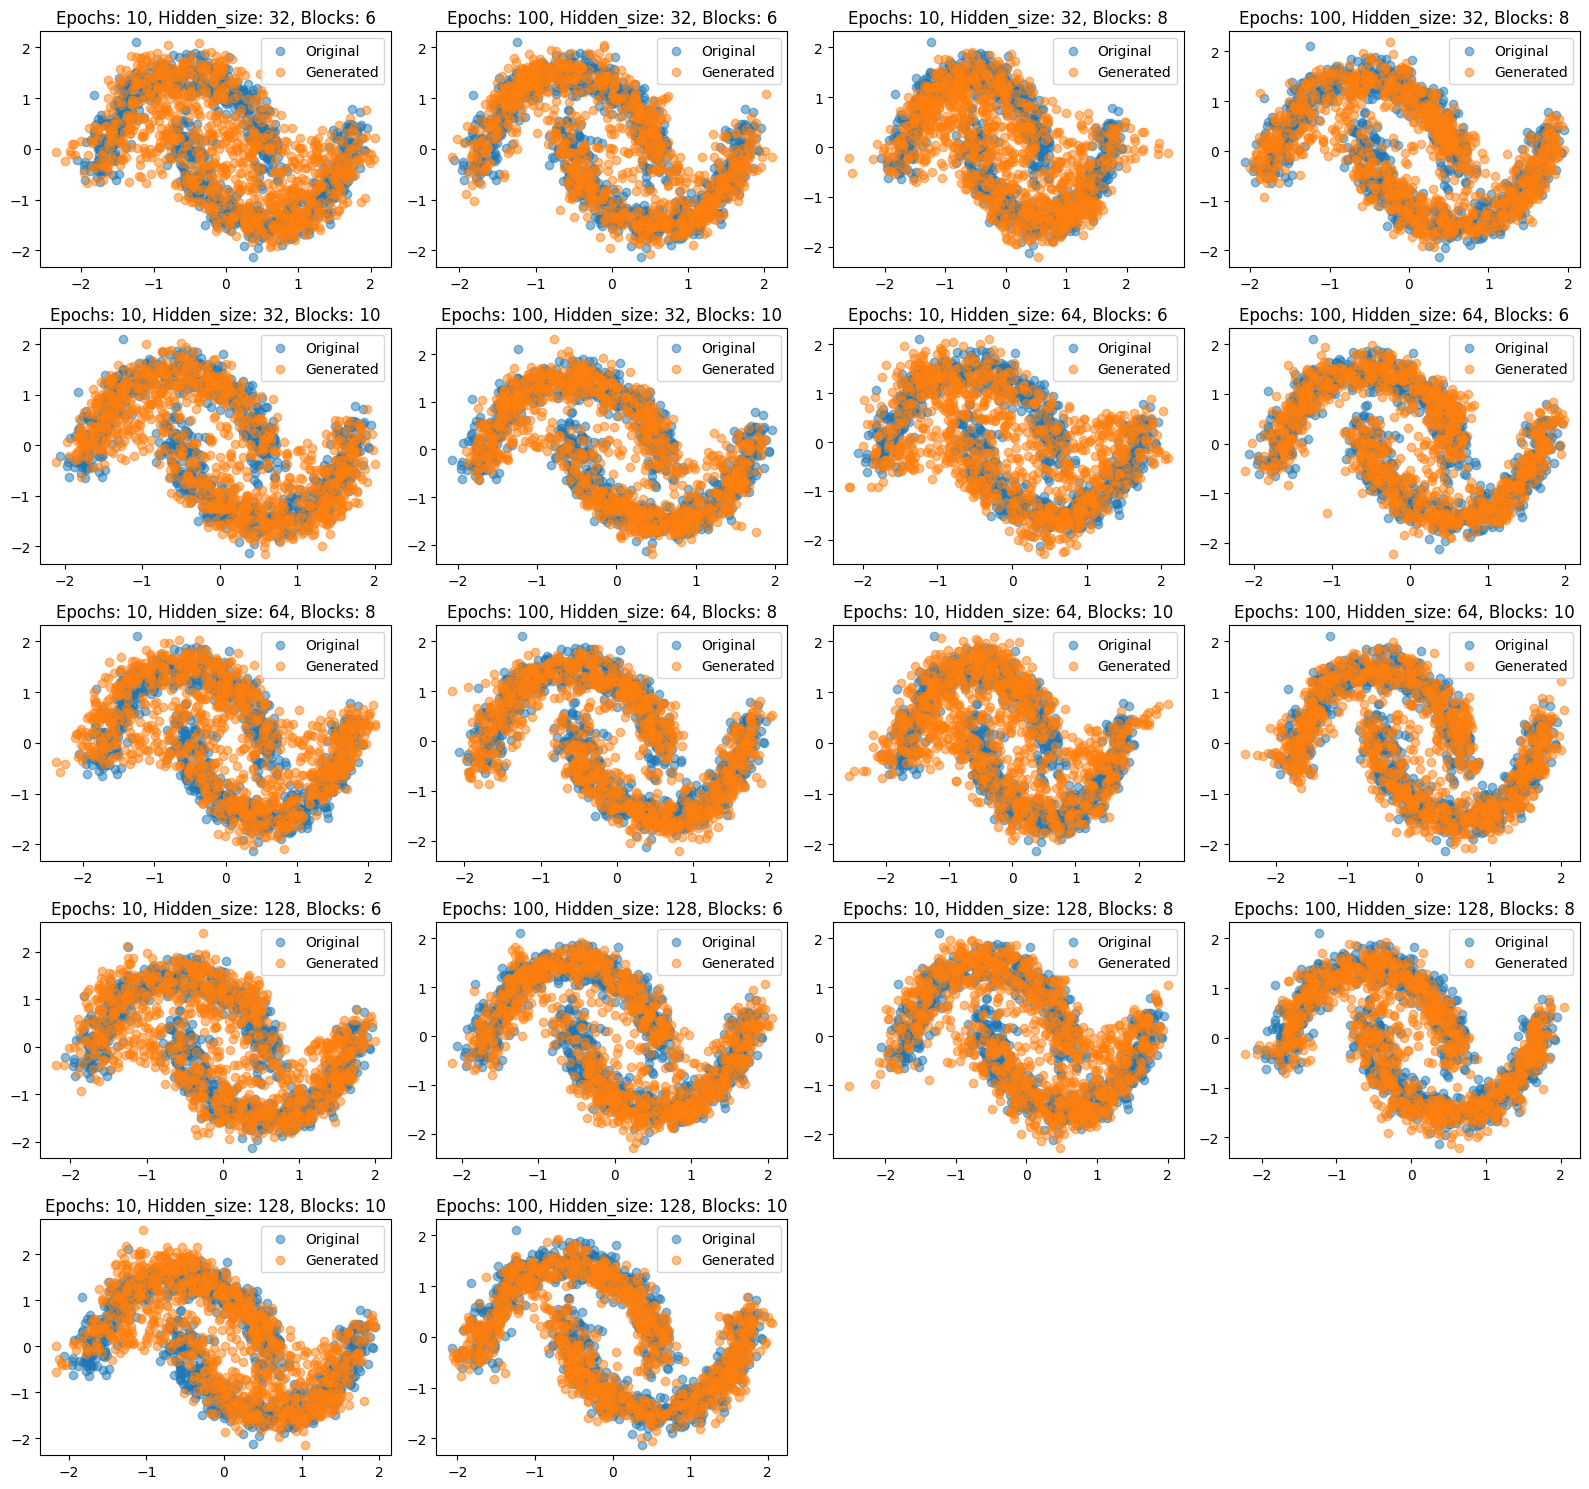

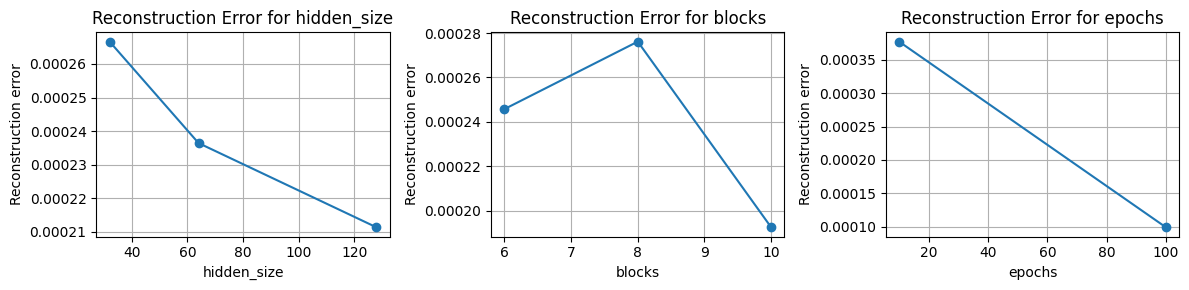

In [9]:
# parameters
n_samples = 1000
noise = 0.1
input_size = 2
lr = 0.001
hidden_size_list = [32, 64, 128]
blocks_list = [6, 8, 10]
epochs_list = [10, 100]

results = evaluate_hyperparameters(n_samples, input_size, lr, hidden_size_list, blocks_list, epochs_list)


MMD

In [10]:
def inverse_multi_quadratic_kernel(x, y, bandwidth=1.0):
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy()
    if isinstance(y, torch.Tensor):
        y = y.detach().numpy()
        
    pairwise_dists = cdist(x, y, metric='sqeuclidean')
    return bandwidth / (bandwidth + pairwise_dists)

def compute_mmd(test_set, generated_set, bandwidth=1.0):
    xx = inverse_multi_quadratic_kernel(test_set, test_set, bandwidth)
    yy = inverse_multi_quadratic_kernel(generated_set, generated_set, bandwidth)
    xy = inverse_multi_quadratic_kernel(test_set, generated_set, bandwidth)
    
    mmd = np.mean(xx) + np.mean(yy) - 2 * np.mean(xy)
    return mmd

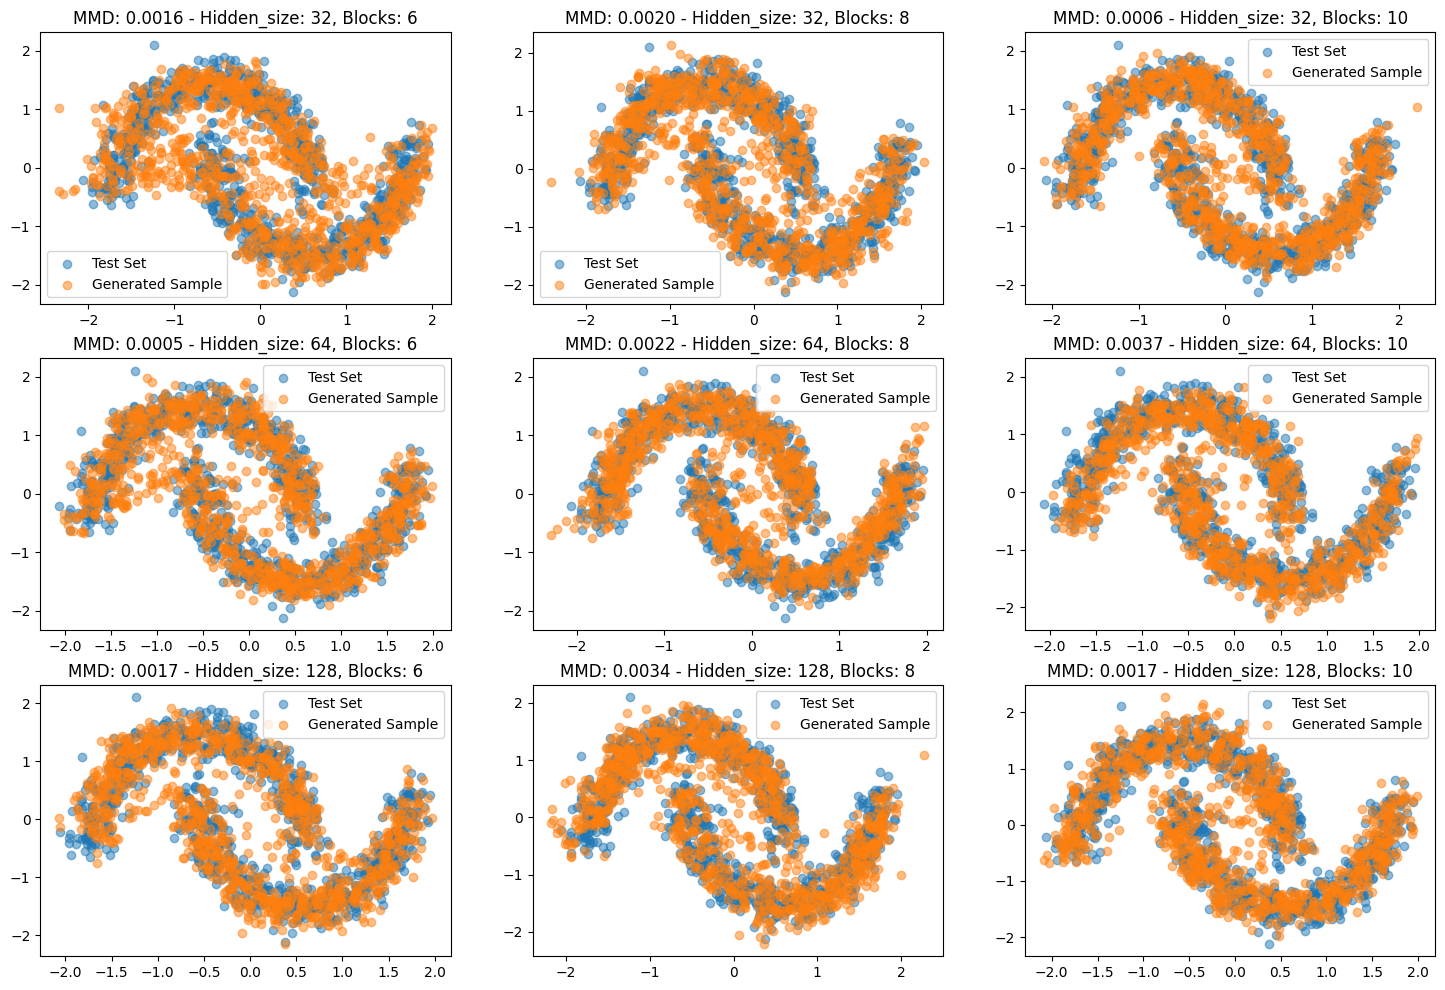

In [ ]:
bandwidth = 1.0
n_samples = 1000
epochs = 100
hidden_size_list = [32, 64, 128]
blocks_list = [6, 8, 10]

test_dataset = generate_data(n_samples, noise, random_state=1)

fig, axes = plt.subplots(len(hidden_size_list), len(blocks_list), figsize=(18, 12))
for i, hidden_size in enumerate(hidden_size_list):
    for j, blocks in enumerate(blocks_list):
        ax = axes[i,j]
        model = RealNVP(input_size, hidden_size, blocks)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        dataset = TensorDataset(test_dataset, torch.zeros(test_dataset.size(0)))
        data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

        train_inn(model, data_loader, optimizer,  epochs)

        # Generate synthetic samples using RealNVP
        generated_samples = model.sample(n_samples).detach().numpy()

        # Compute MMD
        mmd_value = compute_mmd(test_dataset, generated_samples, bandwidth=bandwidth)

        ax.scatter(test_dataset[:, 0], test_dataset[:, 1], alpha=0.5, label='Test Set')
        ax.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, label='Generated Sample')
        ax.set_title(f'MMD: {mmd_value:.4f} - Hidden_size: {hidden_size}, Blocks: {blocks}')
        ax.legend()
plt.legend()
plt.show()


GMM

In [35]:
def hexa_gmm(n_samples, radius=1, std_dev=0.1):
    angles = np.linspace(0, 2 * np.pi, 7)[:-1]  # 6 points on the hexagon
    centers = np.array([[radius * np.cos(angle), radius * np.sin(angle)] for angle in angles])
    
    # dummy data for initialization
    data = np.vstack([np.random.multivariate_normal(center, np.eye(2) * std_dev**2, size=n_samples // 6) for center in centers])
    
    gmm = GaussianMixture(n_components=6, covariance_type='spherical', random_state=42)
    gmm.fit(data)  # Fit the model to the generated data
    
    samples, _ = gmm.sample(n_samples)
    return samples

In [36]:
def train_gmm_inn(model, n_samples, epochs):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Generate data and convert to tensor
        x_data = hexa_gmm(n_samples)
        x_data = torch.tensor(x_data, dtype=torch.float32)  # Convert to PyTorch tensor
        
        z, log_det = model(x_data)
        loss = torch.mean(0.5 * torch.sum(z**2, -1) - log_det)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: -0.0252
Epoch [20/100], Loss: -0.4450
Epoch [30/100], Loss: -0.7006
Epoch [40/100], Loss: -0.7554
Epoch [50/100], Loss: -0.9443
Epoch [60/100], Loss: -1.0132
Epoch [70/100], Loss: -1.0524
Epoch [80/100], Loss: -1.0707
Epoch [90/100], Loss: -1.0913
Epoch [100/100], Loss: -1.1294


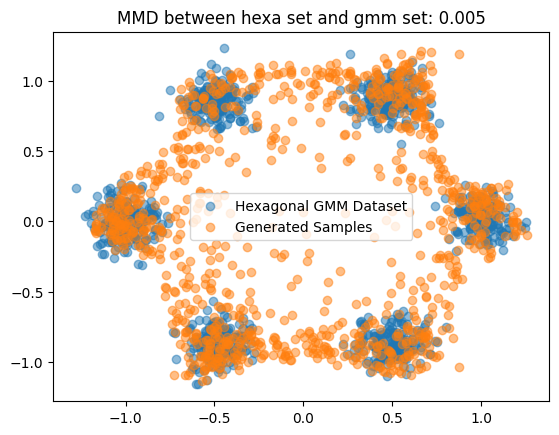

In [37]:
n_samples = 1000
hidden_size = 64
blocks = 10
epochs = 100
radius = 1.0
std_dev = 0.1

hexa_dataset = hexa_gmm(n_samples, radius, std_dev)

gmm_model = RealNVP(input_size, hidden_size=hidden_size, blocks=blocks)
train_gmm_inn(gmm_model, n_samples, epochs)
gmm_dataset = gmm_model.sample(n_samples).detach().numpy()

mmd_value = compute_mmd(hexa_dataset, gmm_dataset, bandwidth=1.0)

plt.scatter(hexa_dataset[:, 0], hexa_dataset[:, 1], alpha=0.5, label='Hexagonal GMM Dataset')
plt.scatter(gmm_dataset[:,0], gmm_dataset[:,1], alpha=0.5, label='Generated Samples')
plt.title(f'MMD between hexa set and gmm set: {mmd_value:.3f}')
plt.legend()
plt.show()